In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from data import tfrecord_labeled_dataset, tfrecord_dataset, train_test_split, kfolds
from layers import SeluConv3D, SeluDense
from plot import plot_volume_animation, plot_loss_history
from config import (
    CT_0_TFRECORD,
    CT_1_TFRECORD,
    CT_2_TFRECORD,
    CT_3_TFRECORD,
    CT_4_TFRECORD,
    COVID_NEG_TFRECORD,
    COVID_POS_TFRECORD,
    SCAN_SHAPE,
    LIDC_NUM_NODULES_TFRECORD,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# LIDC dataset

In [ ]:
lidc_dataset = tfrecord_labeled_dataset(LIDC_NUM_NODULES_TFRECORD)
# lidc_samples = sum(1 for _ in tqdm(lidc_dataset))
lidc_samples = 1141
print(f"{lidc_samples = }")
lidc_dataset

In [11]:
def build_regression_model():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(2, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(2, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            SeluConv3D(filters=256, kernel_size=3, name="selu_conv3d_4"),
            keras.layers.MaxPool3D(2, name="maxpool3d_4"),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(1, name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_regression_model()
m.summary()

Model: "3d_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
selu_conv3d_1 (Conv3D)       (None, 64, 192, 224, 32)  896       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 32, 96, 112, 32)   0         
_________________________________________________________________
selu_conv3d_2 (Conv3D)       (None, 32, 96, 112, 64)   55360     
_________________________________________________________________
maxpool3d_2 (MaxPooling3D)   (None, 16, 48, 56, 64)    0         
_________________________________________________________________
selu_conv3d_3 (Conv3D)       (None, 16, 48, 56, 128)   221312    
_________________________________________________________________
maxpool3d_3 (MaxPooling3D)   (None, 8, 24, 28, 128)    0         
_________________________________________________________________
selu_conv3d_4 (Conv3D)       (None, 8, 24, 28, 256)    88499

In [12]:
val_perc = 0.2
learning_rate = 1e-4
batch_size = 16
patience = 15

In [13]:
train_dataset, val_dataset = train_test_split(
    lidc_dataset, test_perc=val_perc, cardinality=lidc_samples
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [14]:
cnn = build_regression_model()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)
cnn.save("models/lidc-num-nodules-3dcnn.h5")

Epoch 1/1000
58/58 [==============================] - 62s 1s/step - loss: 899.3577 - val_loss: 612.7682
Epoch 2/1000
58/58 [==============================] - 47s 806ms/step - loss: 768.8706 - val_loss: 513.0432
Epoch 3/1000
58/58 [==============================] - 47s 812ms/step - loss: 678.0782 - val_loss: 472.3720
Epoch 4/1000
58/58 [==============================] - 47s 813ms/step - loss: 598.1865 - val_loss: 458.5824
Epoch 5/1000
58/58 [==============================] - 47s 813ms/step - loss: 486.7015 - val_loss: 377.7391
Epoch 6/1000
58/58 [==============================] - 47s 809ms/step - loss: 373.9877 - val_loss: 387.8500
Epoch 7/1000
58/58 [==============================] - 47s 813ms/step - loss: 332.8716 - val_loss: 311.5183
Epoch 8/1000
58/58 [==============================] - 47s 813ms/step - loss: 246.7277 - val_loss: 254.5832
Epoch 9/1000
58/58 [==============================] - 47s 811ms/step - loss: 197.2126 - val_loss: 302.1559
Epoch 10/1000
58/58 [===================

Epoch 78/1000
58/58 [==============================] - 47s 811ms/step - loss: 1.0624 - val_loss: 128.9458
Epoch 79/1000
58/58 [==============================] - 47s 811ms/step - loss: 2.0102 - val_loss: 127.2095
Epoch 80/1000
58/58 [==============================] - 47s 816ms/step - loss: 2.9520 - val_loss: 124.7251
Epoch 81/1000
58/58 [==============================] - 47s 815ms/step - loss: 2.6544 - val_loss: 117.9587
Epoch 82/1000
58/58 [==============================] - 47s 813ms/step - loss: 20.5989 - val_loss: 154.3588
Epoch 83/1000
58/58 [==============================] - 47s 805ms/step - loss: 20.1300 - val_loss: 142.2505
Epoch 84/1000
58/58 [==============================] - 47s 809ms/step - loss: 16.6119 - val_loss: 134.5216
Epoch 85/1000
58/58 [==============================] - 47s 813ms/step - loss: 22.3623 - val_loss: 124.7988
Epoch 86/1000
58/58 [==============================] - 47s 814ms/step - loss: 9.1893 - val_loss: 131.6993
Epoch 87/1000
58/58 [=====================

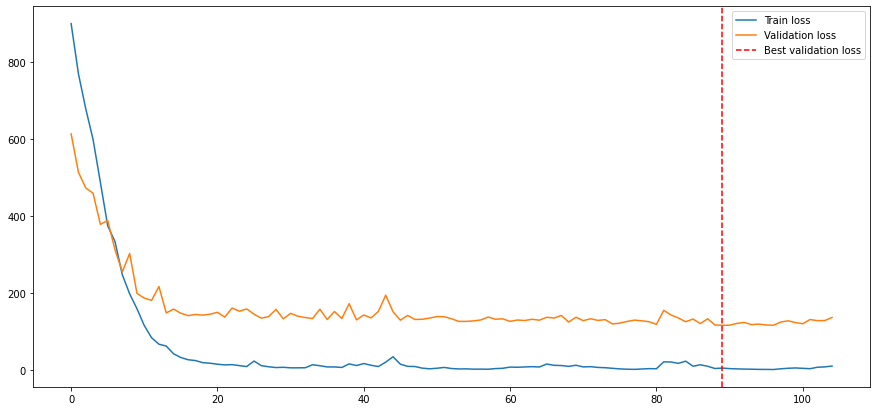

In [15]:
plot_loss_history(history)
plt.savefig("num-nodules-regression-loss.pdf")

In [16]:
#cnn = keras.models.load_model("models/")
for x, y in val_dataset.unbatch().batch(1).take(10).as_numpy_iterator():
    print(f"real: {y}")
    print(f"predicted: {cnn(x, training=False).numpy()}")
    print()

real: [[21]]
predicted: [[20.129894]]

real: [[81]]
predicted: [[79.07425]]

real: [[31]]
predicted: [[16.944345]]

real: [[121]]
predicted: [[117.612755]]

real: [[55]]
predicted: [[56.050587]]

real: [[20]]
predicted: [[20.688055]]

real: [[12]]
predicted: [[11.869031]]

real: [[9]]
predicted: [[28.742336]]

real: [[19]]
predicted: [[17.790829]]

real: [[16]]
predicted: [[14.127807]]



# Covid dataset

In [2]:
neg_x = tfrecord_dataset(COVID_NEG_TFRECORD)
# neg_samples = sum(1 for _ in tqdm(neg_x))
neg_samples = 254  # covid_neg only
print(f"{neg_samples = }")
neg_dataset = tf.data.Dataset.zip(
    (neg_x, tf.data.Dataset.from_tensor_slices(np.int8([[0]])).repeat(neg_samples))
)
# assert sum(1 for _ in tqdm(neg_dataset)) == neg_samples

pos_x = tfrecord_dataset([CT_2_TFRECORD, CT_3_TFRECORD, CT_4_TFRECORD])
# pos_samples = sum(1 for _ in tqdm(pos_x))
# pos_samples = 856  # covid pos
pos_samples = 127  # CT-2 + CT-3 + CT-4 
# pos_x = pos_x.shard(3, index=0)
# pos_samples = sum(1 for _ in pos_x)
print(f"{pos_samples = }")
pos_dataset = tf.data.Dataset.zip(
    (pos_x, tf.data.Dataset.from_tensor_slices(np.int8([[1]])).repeat(pos_samples))
)
# assert sum(1 for _ in tqdm(pos_dataset)) == pos_samples

covid_dataset = neg_dataset.concatenate(pos_dataset)
covid_samples = neg_samples + pos_samples
assert sum(1 for _ in tqdm(covid_dataset)) == covid_samples
print(f"{covid_samples = }")
covid_dataset

neg_samples = 254
pos_samples = 127


|          | 0/? [00:00<?, ?it/s]

covid_samples = 381


<ConcatenateDataset shapes: ((None, None, None, None), (1,)), types: (tf.float32, tf.int8)>

In [4]:
def build_3d_cnn():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(2, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(2, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            SeluConv3D(filters=256, kernel_size=3, name="selu_conv3d_4"),
            keras.layers.MaxPool3D(2, name="maxpool3d_4"),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_3d_cnn()
m.summary()

Model: "3d_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
selu_conv3d_1 (Conv3D)       (None, 64, 192, 224, 32)  896       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 32, 96, 112, 32)   0         
_________________________________________________________________
selu_conv3d_2 (Conv3D)       (None, 32, 96, 112, 64)   55360     
_________________________________________________________________
maxpool3d_2 (MaxPooling3D)   (None, 16, 48, 56, 64)    0         
_________________________________________________________________
selu_conv3d_3 (Conv3D)       (None, 16, 48, 56, 128)   221312    
_________________________________________________________________
maxpool3d_3 (MaxPooling3D)   (None, 8, 24, 28, 128)    0         
_________________________________________________________________
selu_conv3d_4 (Conv3D)       (None, 8, 24, 28, 256)    88499

In [5]:
def build_pretrained_3d_cnn():
    pretrained_3d_cnn = keras.models.load_model("models/lidc-num-nodules-3dcnn.h5")
    pretrained_3d_cnn.pop()  # remove last dense layer
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="pretrained_input"),
            pretrained_3d_cnn,
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="pretrained_3d_cnn",
    )
    pretrained_3d_cnn.trainable = False
    return model


m = build_pretrained_3d_cnn()
m.summary()

Model: "pretrained_3d_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3d_cnn (Sequential)          (None, 172032)            1162560   
_________________________________________________________________
final_dense (Dense)          (None, 1)                 172033    
Total params: 1,334,593
Trainable params: 172,033
Non-trainable params: 1,162,560
_________________________________________________________________


In [ ]:
test_perc = 0.1
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 15

In [ ]:
trainval_dataset, test_dataset = train_test_split(
    covid_dataset, test_perc=test_perc, cardinality=covid_samples
)
train_dataset, val_dataset = train_test_split(trainval_dataset, test_perc=val_perc)
test_dataset = test_dataset.batch(1)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
# cnn = build_3d_cnn()
cnn = build_pretrained_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)

In [ ]:
print(cnn.evaluate(test_dataset, return_dict=True))
plot_loss_history(history)

In [9]:
rounds = 1
fracs = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
test_perc = 0.1
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000
metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [10]:
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
for r in tqdm(range(rounds)):
    print(f" {r = } ")
    full_train_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    # print(f"Test size: {sum(1 for _ in test_dataset)}")
    test_dataset = test_dataset.batch(batch_size)
    full_train_dataset, val_dataset = train_test_split(
        full_train_dataset, test_perc=val_perc
    )
    # print(f"Val size: {sum(1 for _ in val_dataset)}")
    val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    for frac in fracs:
        print(f" {frac = } ")
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        # print(f"Train size: {sum(1 for _ in train_dataset.unbatch())}")

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
               keras.callbacks.EarlyStopping(
                   monitor="val_loss",
                   patience=patience,
                   restore_best_weights=True,
               )
            ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        wo_pt_auc = test_metrics["auc"]
        wo_pt_acc = test_metrics["accuracy"]
        print(f"{wo_pt_auc = }")
        print(f"{wo_pt_acc = }")

        cnn = build_pretrained_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        w_pt_auc = test_metrics["auc"]
        w_pt_acc = test_metrics["accuracy"]
        print(f"{w_pt_auc = }")
        print(f"{w_pt_acc = }")

        data["nn_type"].append("w/o pre-training")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(wo_pt_acc)
        
        data["nn_type"].append("w/o pre-training")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(wo_pt_auc)
        
        data["nn_type"].append("w/ pre-training")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(w_pt_acc)
        
        data["nn_type"].append("w/ pre-training")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(w_pt_auc)
        
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy difference")
        data["metric_value"].append(w_pt_acc - wo_pt_acc)
        
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC difference")
        data["metric_value"].append(w_pt_auc - wo_pt_auc)

    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

  0%|          | 0/1 [00:00<?, ?it/s]

 r = 0 
 frac = 1 
wo_pt_auc = 0.7051281929016113
wo_pt_acc = 0.7631579041481018
w_pt_auc = 0.7083333134651184
w_pt_acc = 0.7105262875556946
 frac = 2 
wo_pt_auc = 0.6987179517745972
wo_pt_acc = 0.7894737124443054
w_pt_auc = 0.7772435545921326
w_pt_acc = 0.7368420958518982
 frac = 3 
wo_pt_auc = 0.6346153616905212
wo_pt_acc = 0.7894737124443054
w_pt_auc = 0.6217948794364929
w_pt_acc = 0.7368420958518982
 frac = 4 
wo_pt_auc = 0.634615421295166
wo_pt_acc = 0.7368420958518982
w_pt_auc = 0.6089743375778198
w_pt_acc = 0.6842105388641357
 frac = 5 
wo_pt_auc = 0.7499999403953552
wo_pt_acc = 0.7105262875556946
w_pt_auc = 0.47275638580322266
w_pt_acc = 0.44736841320991516
 frac = 6 
wo_pt_auc = 0.5705127716064453
wo_pt_acc = 0.6315789222717285
w_pt_auc = 0.7788461446762085
w_pt_acc = 0.7368420958518982
 frac = 7 
wo_pt_auc = 0.6314102411270142
wo_pt_acc = 0.6578947305679321
w_pt_auc = 0.4407051205635071
w_pt_acc = 0.5263158082962036
 frac = 8 
wo_pt_auc = 0.6602563858032227
wo_pt_acc = 0.6578

In [17]:
for k, v in data.items():
    print(k, len(v))

train_size_fraction 60
metric 60
metric_value 60


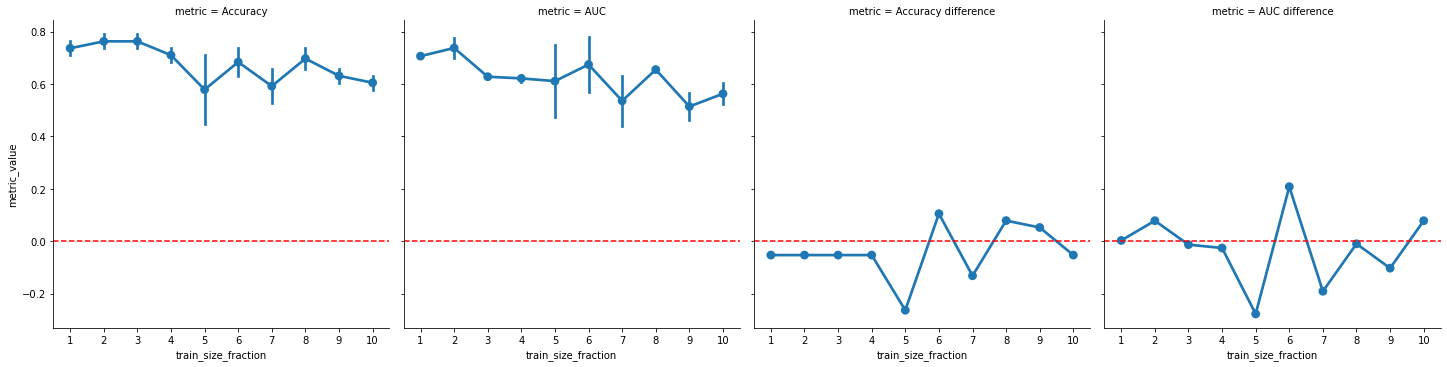

In [18]:
g = sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    col="metric",
    kind="point",
    data=pd.DataFrame(data),
)
for ax in g.axes[0]:
    ax.axhline(color="r", ls="--")

In [ ]:
round_index = 3
frac_index = 4
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()

In [ ]:
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
for _ in tqdm(range(rounds)):
    trainval_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    test_dataset = test_dataset.batch(batch_size)
    full_train_dataset, val_dataset = train_test_split(
        trainval_dataset, test_perc=val_perc
    )
    val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    for frac in fracs:
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/o pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])

        cnn = build_pretrained_3d_cnn(True)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/ pretraining (conv freezing)")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

In [ ]:
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=pd.DataFrame(data),
)

In [ ]:
round_index = 1
frac_index = 0
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()

In [ ]:
k = 10
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000

In [ ]:
wo_pt_histories = []
wo_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
w_pt_histories = []
w_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, covid_dataset, cardinality=covid_samples)), total=k
):
    test_dataset = test_dataset.batch(1)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    wo_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in wo_pt_metrics:
            metric.update_state(test_y, pred_y)

    cnn = build_pretrained_3d_cnn(True)
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in w_pt_metrics:
            metric.update_state(test_y, pred_y)

print(" total ".center(50, "="))
print("Without pretraining: ")
for metric in wo_pt_metrics:
    print(f"{metric.name}: {metric.result()}")
print("")

print("With pretraining (w/ conv freezing): ")
for metric in w_pt_metrics:
    print(f"{metric.name}: {metric.result()}")

In [ ]:
index = 0
plt.plot(
    wo_pt_histories[index].history["loss"], "--", label="w/o pre-training - train loss"
)
plt.plot(
    wo_pt_histories[index].history["val_loss"], label="w/o pre-training - val loss"
)
plt.plot(
    w_pt_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
plt.plot(
    w_pt_conv_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_conv_histories[index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()